In [ ]:
!pip install pyspark
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#Buat Spark Session
spark = SparkSession.builder.getOrCreate()

# 1. Load Data
# Training
df_train = spark.read.option("inferSchema", "true").csv("Classification_Train.csv", header = True)
df_test = spark.read.option("inferSchema", "true").csv("Classification_Test.csv", header = True)

df_train.show(10)
df_test.show(10)

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|_c0|    id|Gender|    Customer Type|Age| Type of Travel|   Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        satisfaction|
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+-

In [ ]:
df_train = df_train.select("Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking","Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness", "satisfaction")
df_test = df_test.select("Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking","Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness", "satisfaction")

df_train.show(10)
df_test.show(10)

+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------+
|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|        satisfaction|
+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------+
|                    3|                                4|                     3|            1|             5|              3|           5|                     5|  

In [ ]:
# 3. Data Preprocessing -> menghilangkan data yang nilainya NULL

#df_train.isnull().sum()

df_train = df_train.na.drop()
df_test = df_test.na.drop()

In [ ]:
# 4. Transform Data -> Data yang dalam bentuk kategori diubah menjadi dalam bentuk angka

from pyspark.sql.functions import when

def transform(df):
  # Transform Education Level
  df = df.withColumn("satisfaction", when(df["satisfaction"] == "satisfied", 0).otherwise(1))

  return df

df_train = transform(df_train)
df_test = transform(df_test)

# Cek hasil
df_train.show(10)
df_test.show(10)

+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+------------+
|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|satisfaction|
+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+------------+
|                    3|                                4|                     3|            1|             5|              3|           5|                     5|               4|         

In [ ]:
# 5. Normalization
# VectorAssembler -> mengabungkan semua feature ke dalam satu column
# StandarScalor -> standarisasi skala, dibuat rata-rata seluruh data bernilai 0 dan standard deviasinya bernilai 1


from pyspark.ml.feature import VectorAssembler, StandardScaler

def normalize(df):
  # Hapus kolom satisfaction
  cols = df.columns
  cols.remove("satisfaction")

  # Gabungin Feature
  df = VectorAssembler(inputCols = cols, outputCol = "Features").transform(df)

  # Standarisasi skala
  df = StandardScaler(inputCol = "Features", outputCol = "Scaled Features").fit(df).transform(df)

  return df

df_train = normalize(df_train)
df_test = normalize(df_test)

# Cek hasil
df_train.show(10)
df_test.show(10)

+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+------------+--------------------+--------------------+
|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|satisfaction|            Features|     Scaled Features|
+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+------------+--------------------+--------------------+
|                    3|                                4|    

In [ ]:
# 6. Generate Model

from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(featuresCol = "Scaled Features", labelCol = "satisfaction", maxIter = 10).fit(df_train)
prediction = model.transform(df_test)

prediction.select("Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking","Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness", "prediction").show(10)

prediction

+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+----------+
|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|prediction|
+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+----------+
|                    5|                                4|                     3|            4|             3|              4|           3|                     5|               5|               

DataFrame[Inflight wifi service: int, Departure/Arrival time convenient: int, Ease of Online booking: int, Gate location: int, Food and drink: int, Online boarding: int, Seat comfort: int, Inflight entertainment: int, On-board service: int, Leg room service: int, Baggage handling: int, Checkin service: int, Inflight service: int, Cleanliness: int, satisfaction: int, Features: vector, Scaled Features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
# 7. Evaluation

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = "satisfaction")
accuracy = evaluator.evaluate(prediction)

print(accuracy)

0.8752547563765845


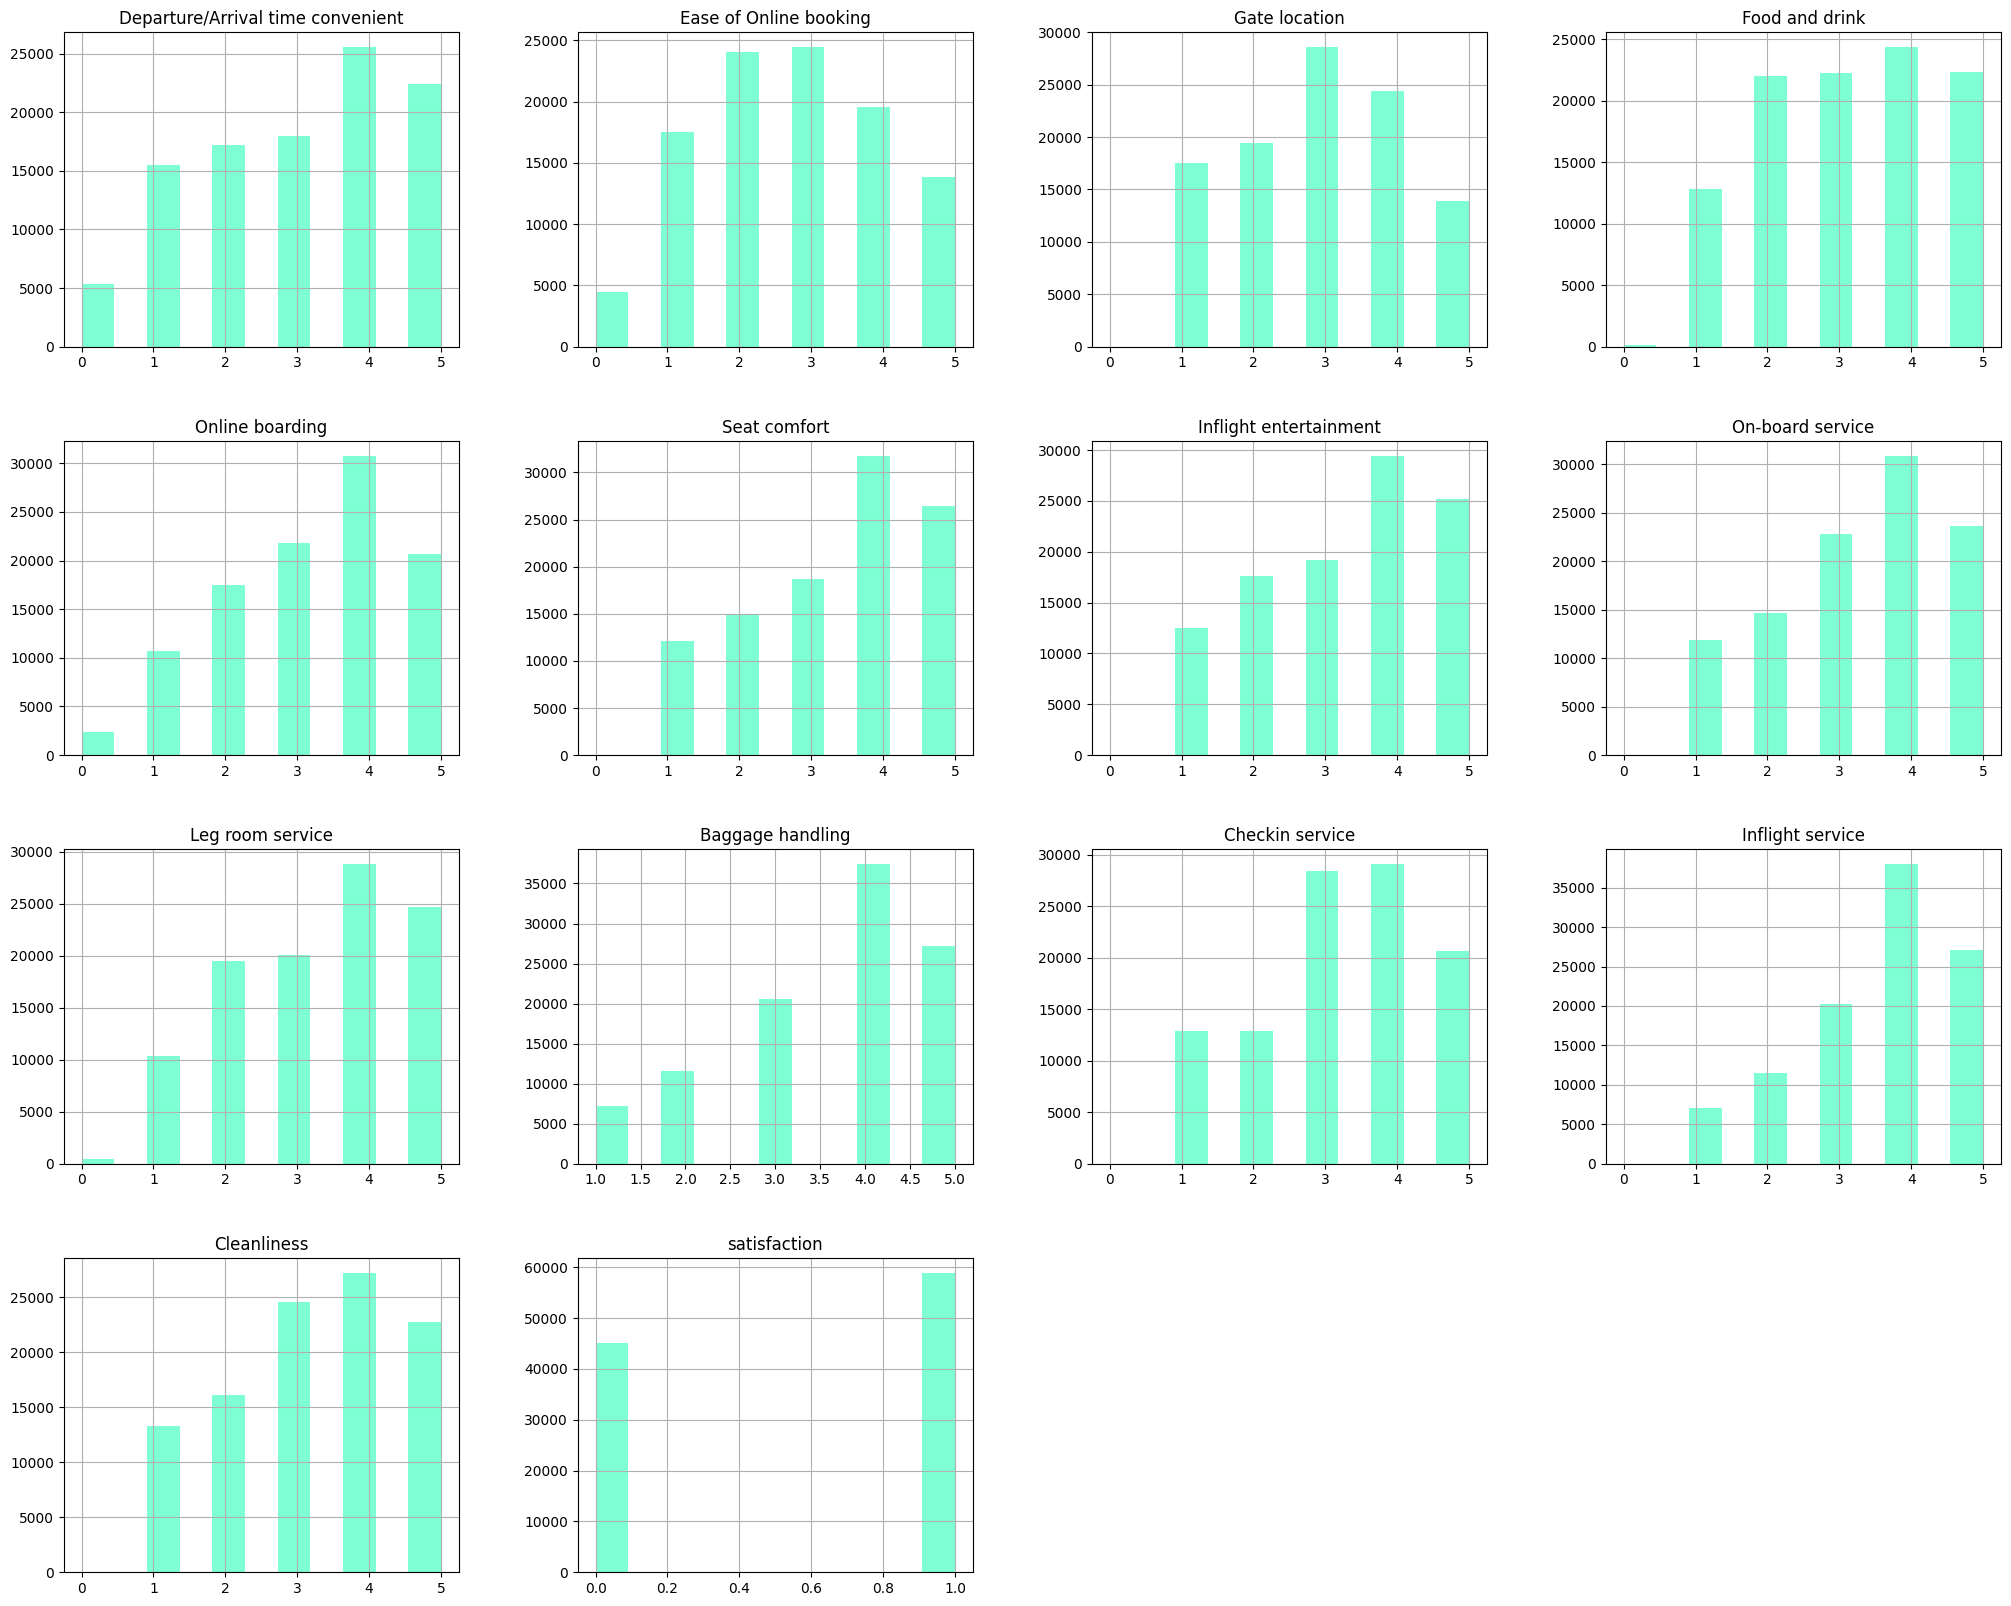

In [ ]:
df_train = df_train.toPandas()

binwidth=2
df_train.iloc[:,1:].hist(bins=11, figsize=(25,20), color='aquamarine')
plt.show()